# Imports

In [3]:
import os
import torch

import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt

from tqdm import tqdm

phi_idx1, phi_idx2, phi_idx3, phi_idx4 = 4, 6, 8, 14
psi_idx1, psi_idx2, psi_idx3, psi_idx4 = 6, 8, 14, 16

In [4]:
def compute_two_dihedral(pdb_file):
	traj = md.load(pdb_file)
	indices_psi = [psi_idx1, psi_idx2, psi_idx3, psi_idx4]
	indices_phi = [phi_idx1, phi_idx2, phi_idx3, phi_idx4]
	psi= md.compute_dihedrals(traj, [indices_psi])[0][0] * 180 / np.pi
	phi = md.compute_dihedrals(traj, [indices_phi])[0][0] * 180 / np.pi

	return psi, phi

# Dihedral angles check

In [5]:
file_list = os.listdir('../projection/alanine')
print(len(file_list))

16021


In [6]:
psi_list = []
phi_list = []

for file in tqdm(file_list):
	file_name = f"../projection/alanine/{file}"
	psi, phi = compute_two_dihedral(file_name)
	psi_list.append(psi)
	phi_list.append(phi)

100%|██████████| 16021/16021 [00:11<00:00, 1338.37it/s]


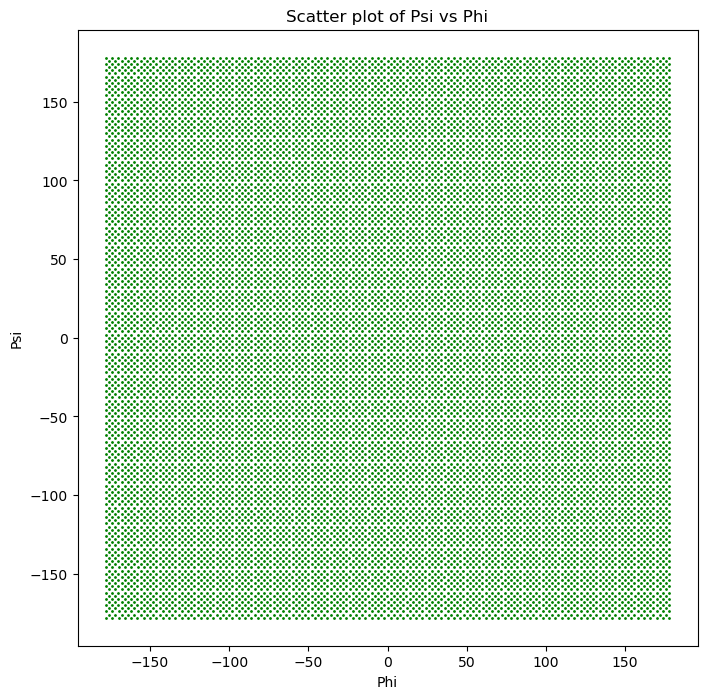

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(psi_list, phi_list, alpha=1, s=1, color="green")
plt.title('Scatter plot of Psi vs Phi')
plt.xlabel('Phi')
plt.ylabel('Psi')
plt.show()

In [8]:
print(np.array(psi_list).shape)
np.save('../projection/alanine_psi_list.npy', np.array(psi_list) / 180 * np.pi)
print(np.array(phi_list).shape)
np.save('../projection/alanine_phi_list.npy', np.array(phi_list) / 180 * np.pi)

(16021,)
(16021,)


# PT file creation

In [9]:
ALANINE_HEAVY_ATOM_IDX = [
    1, 4, 5, 6, 8, 10, 14, 15, 16, 18
]

def coordinate2distance(position):
    position = position.reshape(-1, 3)
    heavy_atom_position = position[ALANINE_HEAVY_ATOM_IDX]
    num_heavy_atoms = len(heavy_atom_position)
    distance = []
    for i in range(num_heavy_atoms):
        for j in range(i+1, num_heavy_atoms):
            distance.append(torch.norm(heavy_atom_position[i] - heavy_atom_position[j]))
    distance = torch.stack(distance)
    
    return distance

In [10]:
distance_list = []
coordinate_list = []

for file in tqdm(file_list):
	file_name = f"../projection/alanine/{file}"
	xyz = md.load(file_name).xyz[0]
	xyz_torch = torch.tensor(xyz, dtype=torch.float32)
	coordinate_list.append(xyz_torch)
	distance = coordinate2distance(xyz_torch)
	distance_list.append(distance)

100%|██████████| 16021/16021 [00:20<00:00, 785.92it/s]


In [11]:
distance_dataset = torch.stack(distance_list)
print(f"Distance dataset: {distance_dataset.shape}")

Distance dataset: torch.Size([16021, 45])


In [12]:
torch.save(distance_dataset, '../projection/alanine_heavy_atom_distance.pt')

In [13]:
coordinate_dataset = torch.stack(coordinate_list)
print(f"Coordinate dataset: {coordinate_dataset.shape}")

Coordinate dataset: torch.Size([16021, 22, 3])


In [14]:
torch.save(coordinate_dataset, '../projection/alanine_coordinate.pt')